**Data Mining and Machine Learning - Assignment 1**

# Question 1 - NOx Study

Modelling of $LNOx$ concentration as function of other variables 

In [1]:
# Import of used libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

In [2]:
# Import of the dataset
q1_pd = pd.read_csv('NOxEmissions.csv')
q1_pd

,rownames,julday,LNOx,LNOxEm,sqrtWS
0,193,373,4.457250,5.536489,0.856446
1,194,373,4.151827,5.513000,1.016612
2,195,373,3.834061,4.886994,1.095445
3,196,373,4.172848,5.138912,1.354068
4,197,373,4.322807,5.666518,1.204159
...,...,...,...,...,...
8083,8779,730,5.000585,6.730993,1.396424
8084,8780,730,4.669552,6.165086,1.466288
8085,8781,730,4.380776,5.855493,1.559808
8086,8782,730,4.284276,5.691445,1.449138


## (a) - Data Pre-processing

In the Pre-Processing stage, the following actions were made:

- **Missing data:** No missing data found in the dataset
- **Duplicates:** No duplicates were found.

In [3]:
# (a) - Pre-processing

# Check if missing/duplicated/Invalid data is present in the dataset

## Missing data
print(f"Number of missing data: {q1_pd.isnull().sum().sum()}")
## Duplicated data
print(f"Number of duplicated data: {q1_pd.duplicated().sum()}")

## Statistical Summary
print(f"===Statistical Summary===\n{q1_pd.describe()}")


Number of missing data: 0
Number of duplicated data: 0
===Statistical Summary===
          rownames       julday         LNOx       LNOxEm       sqrtWS
count  8088.000000  8088.000000  8088.000000  8088.000000  8088.000000
mean   4597.584570   556.078882     4.378691     7.338244     1.365253
std    2464.686179   102.706509     0.937389     1.016658     0.466280
min     193.000000   373.000000    -0.105361     4.157866     0.316228
25%    2507.750000   469.000000     3.891820     6.514982     1.016612
50%    4681.500000   560.000000     4.497028     7.692495     1.284523
75%    6709.250000   644.000000     5.012134     8.239159     1.648181
max    8783.000000   730.000000     6.576121     8.600040     3.624017


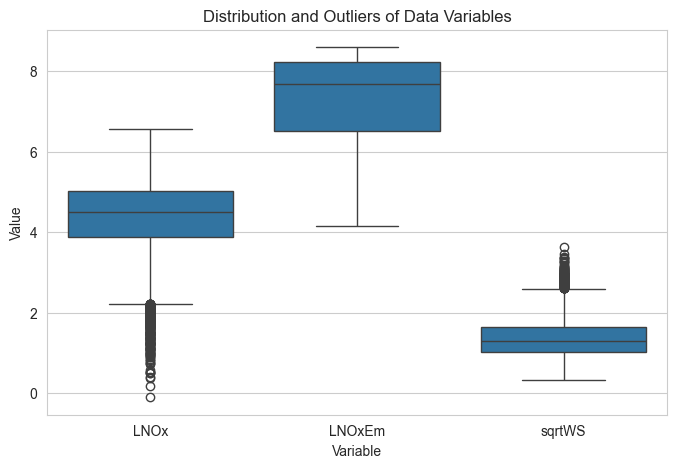

In [4]:
# Check for outliers

melted_data = pd.melt(q1_pd, value_vars=['LNOx', 'LNOxEm', 'sqrtWS'], var_name='Variable', value_name='Value')
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5)) 
boxplot = sns.boxplot(x='Variable', y='Value', data=melted_data)
boxplot.set_title('Distribution and Outliers of Data Variables')
boxplot.set_ylabel('Value')
boxplot.set_xlabel('Variable')

plt.show()

## (b) - Distribution of LNOx variable

$LNOx$ appears to follow a normal distribution with a significant number of outliers on the left side (as shown by the previous box-plot).
A left (negative) skew is also identified from the graph and by using the *Skewness* indicator. 

Mean: 4.378690810185019
Median: 4.49702802736839
Standard Deviation: 0.937388582502527
Variance: 0.8786973546060968
Range: 6.681481834658996
Skewness: -0.8244320335510329
Kurtosis: 1.1307787937580986


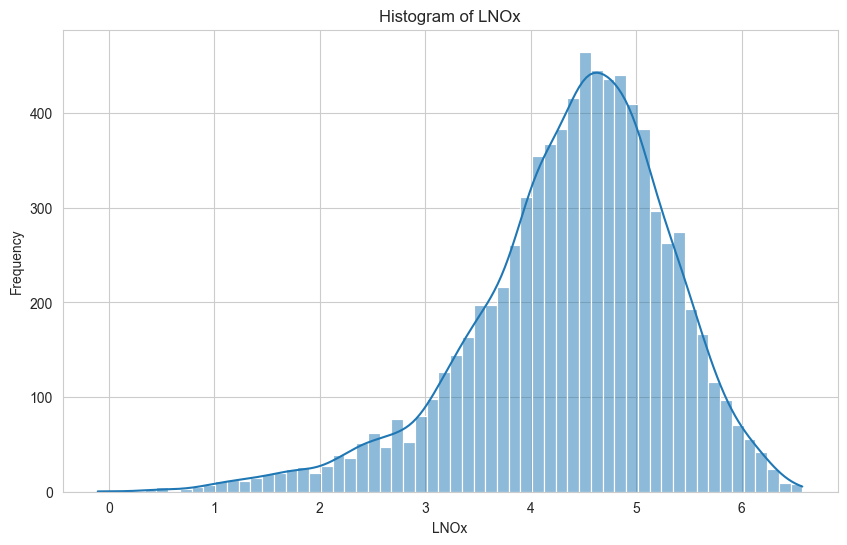

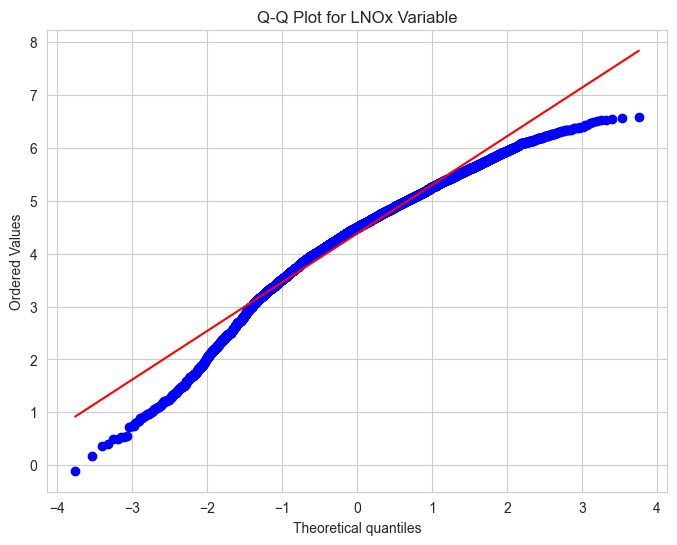

In [5]:
# (b) - LNOx distribution

lnox = q1_pd['LNOx']

## Descriptive Stats
range_lnox = lnox.max() - lnox.min()
print(f"Mean: {lnox.mean()}\nMedian: {lnox.median()}\nStandard Deviation: {lnox.std()}\nVariance: {lnox.var()}\nRange: {range_lnox}\nSkewness: {lnox.skew()}\nKurtosis: {lnox.kurt()}")

## Histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(q1_pd['LNOx'], kde=True)
plt.title('Histogram of LNOx')
plt.xlabel('LNOx')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(q1_pd['LNOx'], dist="norm", plot=ax)
ax.set_title("Q-Q Plot for LNOx Variable")
plt.show()

## (c) - Linear Model of LNOx as fn. of LNOxEm, sqrtWS

The $LNOx$ linear model is fitted below using a multiple linear regression model, $LNOx$ is the dependent variable, $LNOxEm$ and $sqrtWS$ are the independent variables.

The OLS-regression results from the model shows that:

- $R^2 = 0.663$, which means that the independent variables can explain about $66\%$ of variability of $LNOx$.
- The coefficients of the independent variables explains:
    - $LNOxEm$: When this variable increases, $LNOx$ **increases** too by a factor of $\approx 0.06$.
    - $sqrtWS$: When the square root of wind speed increases, $LNOx$ gets **decreased** by a factor of $\approx 1.01$


In [6]:
# (c) - LNOx linear model 

X = q1_pd[['LNOxEm', 'sqrtWS']]
X = sm.add_constant(X)
y = q1_pd['LNOx']
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   LNOx   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     7952.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:12:09   Log-Likelihood:                -6554.7
No. Observations:                8088   AIC:                         1.312e+04
Df Residuals:                    8085   BIC:                         1.314e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0619      0.046     23.097      0.000       0.972       1.152
LNOxEm         0.6414      0.006    107.092      0.000       0.630       0.653
sqrtWS        -1.0182      0.013    -77.969      0.000      -1.044      -0.993
==============================================================================
Omnibus:                       28.937   Durbin-Watson:                   0.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.943
Skew:                          -0.115   Prob(JB):                     1.91e-07
Kurtosis:                       3.198   Cond. No.                         58.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (d) - Relationship between dependent and independent variables

In the Linear Regression model created above, the concentration of nitrogen close to a motorway ($LNOx$, the dependent variable) is influenced by:

- The emission of $NOx$ of cars on the motorway ($LNOxEm$)
- The square root of wind speed ($sqrtWS$)

The results of the model shows that both (independent) variables are significant in determining the concentration of $NOx$. An increase of the wind speed ($sqrtWS$) tends to lower the concentration of $NOx$, probably because it would disperse the $NOx$ present in the air. 
On the other hand, $LNOxEm$ has a positive impact on the concentration of $NOx$. This likely means that when the volume of emissions of cars in the motorway increases, so does the $NOx$ concentration close to the motorway. However, this affects the concentration of nitrogen less than the wind does.

## (e) - Prediction of LNOx given the indp. variables values

Given the value of the emission of cars in the motorway ($LNOxEm = 7.5$) and wind speed ($sqrtWS = 1.3$) the estimated value for the concentration of pollution close to the motorway is $LNOx \approx 4.55$. This means that given the amount of pollution the cars are making ($7.5$) and how fast the wind is blowing ($1.3$) the air pollution is expected to be around $4.55$.

By consulting the data available, the prediction is close to the average concentration of pollution, suggesting that the prediction is within reasonable ranges.

The predicted LNOx value is: 4.55


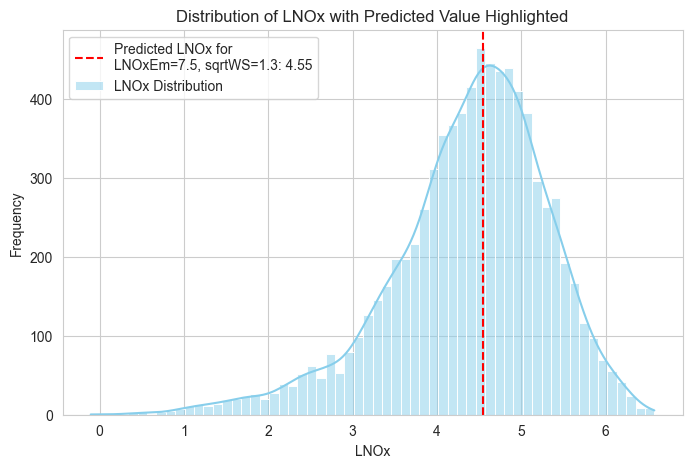

In [7]:
# (e) - prediction using pre-defined values

# LNOxEm = 7.5, sqrtWS = 1.3
new_data = pd.DataFrame({'const': 1, 'LNOxEm': [7.5], 'sqrtWS': [1.3]})
predicted_LNOx = model.predict(new_data)
print(f"The predicted LNOx value is: {predicted_LNOx[0]:.2f}")

# Distribution + predicted value
plt.figure(figsize=(8, 5))
sns.histplot(q1_pd['LNOx'], kde=True, color="skyblue", label='LNOx Distribution')
plt.axvline(x=predicted_LNOx[0], color='red', linestyle='--', label=f'Predicted LNOx for\nLNOxEm=7.5, sqrtWS=1.3: {predicted_LNOx.iloc[0]:.2f}')
plt.legend()
plt.title('Distribution of LNOx with Predicted Value Highlighted')
plt.xlabel('LNOx')
plt.ylabel('Frequency')
plt.show()

# Question 2 - Airbag study

Modelling the probability of surviving a crash given 7 variables, using a *Generalized Linear Model*.


In [8]:
# Q2 - Dataset load + visualization
q2_pd = pd.read_csv('nassCDS.csv')
q2_pd

,rownames,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid
0,1,25-39,25.069,alive,none,belted,1,f,26,1997,1990.0,unavail,driver,0,3.0,2:3:1
1,2,10-24,25.069,alive,airbag,belted,1,f,72,1997,1995.0,deploy,driver,1,1.0,2:3:2
2,3,10-24,32.379,alive,none,none,1,f,69,1997,1988.0,unavail,driver,0,4.0,2:5:1
3,4,25-39,495.444,alive,airbag,belted,1,f,53,1997,1995.0,deploy,driver,1,1.0,2:10:1
4,5,25-39,25.069,alive,none,belted,1,f,32,1997,1988.0,unavail,driver,0,3.0,2:11:1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26212,26213,25-39,3179.688,alive,none,belted,1,m,17,2002,1985.0,unavail,driver,0,0.0,82:107:1
26213,26214,10-24,71.228,alive,airbag,belted,1,m,54,2002,2002.0,nodeploy,driver,0,2.0,82:108:2
26214,26215,10-24,10.474,alive,airbag,belted,1,f,27,2002,1990.0,deploy,driver,1,3.0,82:110:1
26215,26216,25-39,10.474,alive,airbag,belted,1,f,18,2002,1999.0,deploy,driver,1,0.0,82:110:2


## (a) - Data Pre-Processing

The dataset has $154$ missing values. Considering that the dataset is very numerous, to avoid having problems with predictions, all the records with missing values are dropped. 

As GLM will be applied to predict the *dead* variable, a histogram is used to check for an imbalance between the two groups of the *dead* variable (fatal / non-fatal crashes).
The graph below shows that there is a big imbalance between the data for fatal/non-fatal crashes. To address this problem, the data of fatal crashes will be upsampled in order to match the number of data related to non-fatal crashes.

In [9]:
# 2.1 - Dataset load and Pre-Processing

## Missing data
print(f"Number of missing data: {q2_pd.isnull().sum().sum()}")
## Duplicated data
print(f"Number of duplicated data: {q2_pd.duplicated().sum()}")

## Statistical Summary
print(f"===Statistical Summary===\n{q2_pd.describe()}")

# Drop all the records with missing data
q2_clean_pd = q2_pd.dropna()

Number of missing data: 154
Number of duplicated data: 0
===Statistical Summary===
          rownames        weight       frontal      ageOFocc       yearacc  \
count  26217.00000  26217.000000  26217.000000  26217.000000  26217.000000   
mean   13109.00000    462.811611      0.643323     37.206202   1999.555556   
std     7568.34034   1524.844430      0.479027     17.909317      1.702546   
min        1.00000      0.000000      0.000000     16.000000   1997.000000   
25%     6555.00000     32.467000      0.000000     22.000000   1998.000000   
50%    13109.00000     86.986000      1.000000     33.000000   2000.000000   
75%    19663.00000    364.717000      1.000000     48.000000   2001.000000   
max    26217.00000  57871.595000      1.000000     97.000000   2002.000000   

            yearVeh        deploy   injSeverity  
count  26216.000000  26217.000000  26064.000000  
mean    1992.804699      0.337033      1.715508  
std        5.594990      0.472705      1.293357  
min     1953.0

dead
alive    24883
dead      1180
Name: dead, dtype: int64


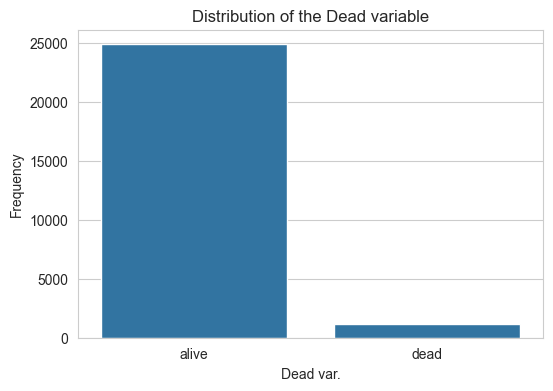

In [10]:
# Check for data imbalance / plot
dead_count = q2_clean_pd.groupby("dead")["dead"].count()
print(dead_count)

plt.figure(figsize=(6, 4))
sns.barplot(data=dead_count)
plt.xlabel('Dead var.')
plt.ylabel('Frequency')
plt.title('Distribution of the Dead variable')
plt.show()

In [11]:
from sklearn.utils import resample

# up-sampling the dataset

q2_df_minority = q2_clean_pd[(q2_clean_pd['dead'] == 'dead')]
q2_df_majority = q2_clean_pd[(q2_clean_pd['dead'] == 'alive')]

q2_df_minority_upsampled = resample(q2_df_minority, replace=True, n_samples=dead_count[0], random_state=42)
q2_df_minority_upsampled.reset_index(drop=True, inplace=True)

q2_df_upsampled = pd.concat([q2_df_minority_upsampled, q2_df_majority])

dead_count2 = q2_df_upsampled.groupby("dead")["dead"].count()
print("==Upsampled dataset count==")
print(dead_count2)

==Upsampled dataset count==
dead
alive    24883
dead     24883
Name: dead, dtype: int64


C:\Users\tommc\AppData\Local\Temp\ipykernel_24616\2119681165.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q2_df_minority_upsampled = resample(q2_df_minority, replace=True, n_samples=dead_count[0], random_state=42)


## (b) - is Seat Belt var. independent related to the dead var.

Considering the following hypothesis:

- $H_0$: seatbelt use is independent of whether a passenger survives or not
- $H_1$: seatbelt use is not independent of whether a passenger survives or not

The Seat Belt is not independent whether the passenger survives or not, which is checked by the $\chi^2$ test between the seatbelt and "dead" data. Having the P-value very close to zero rejects the *Null Hypothesis* $H_0$, indicating that the usage of the seatbelt is likely to influence the survival outcome.

In [12]:
from scipy.stats import chi2_contingency

table = pd.crosstab(q2_clean_pd['seatbelt'], q2_clean_pd['dead'])
print(table)

# Chi-square test
chi2, p, _, _ = chi2_contingency(table)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")

dead      alive  dead
seatbelt             
belted    17965   500
none       6918   680
Chi-square Statistic: 483.7579238069682
P-value: 3.2511305843401275e-107


## (c) - Mean age difference between inj. severity groups

The box plot below shows that there is a significant difference of the mean age between the 5 groups of injury. The difference is more evident with the "Killed" group, where the median is significantly greater than the other, reaching a value of $\approx 40$.

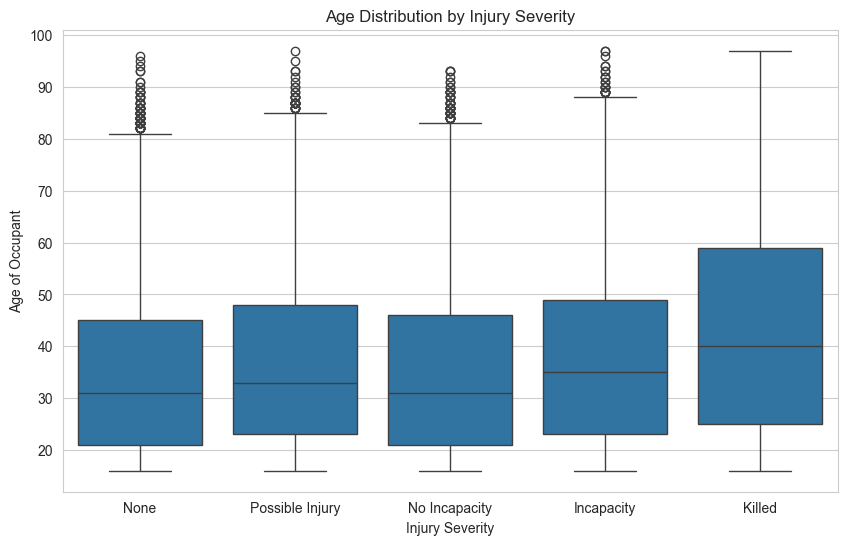

In [13]:
# Box plot visualization
q2_filtered = q2_clean_pd[q2_clean_pd['injSeverity'] < 5]

plt.figure(figsize=(10, 6))
sns.boxplot(x='injSeverity', y='ageOFocc', data=q2_filtered)
plt.title('Age Distribution by Injury Severity')
plt.xlabel('Injury Severity')
plt.ylabel('Age of Occupant')
plt.xticks([0, 1, 2, 3, 4], ['None', 'Possible Injury', 'No Incapacity', 'Incapacity', 'Killed'])
plt.show()

## (d) - GLM for prob. of surviving

The GLM will try to predict the probability of surviving as a function of *airbag*, *seatbelt*, *frontal*, *sex*, *ageOFocc*, *yearVeh*, *deploy* using **70%** to train the model and **30%** of the remaining  data to test it.

Before training the model using 70% of the dataset over dispersion was checked by using the $OD = \frac{\text{pearson's } \chi^2}{\text{Df residuals}}$ and the scale value of the *Quasi-binomial* model.
The test results suggests that there is not enough evidence to show that the model is inadequate.

yearVeh was removed from the final formula for the GLM as it does not contribute enough to the result (P value).

### Comment on GLM model performance

The Binomial GLM model evaluation showed the following results:

- $Accuracy = 0.6812 \approx 68\%$, this means that out of 100 predictions about a person surviving or not a crash, the model correctly predicts only 68 times.
- $Sensitivity = 0.6847 \approx 68\%$, this indicator shows that for every 100 persons that actually survived the crash the model correctly predicts only 68 of them.
- $Specificity = 0.6777 \approx 68\%$, means that for every 100 persons that did not manage to survive the crash the model only correctly identifies 68 of them.

The results show that the model should be improved to better predict a fatal crash. One of the possible reasons for the low accuracy could be how the prediction, expressed as a decimal number from 0 to 1 get converted to a nominal value of either 'dead' or 'alive'. In this model if the value is $< 0.5$ then the prediction is labeled as 'dead', 'alive' is assigned otherwise. 

In [14]:
from statsmodels.formula.api import glm

# First step - Check for over dispersion and define formula

glm_formula = 'dead ~ C(airbag) + C(seatbelt) + C(frontal) + C(sex) + ageOFocc + yearVeh + C(deploy)'

glm_model = glm(formula=glm_formula, data=q2_df_upsampled, family=sm.families.Binomial()).fit()
glm_model_x2 = glm(formula=glm_formula, data=q2_df_upsampled, family=sm.families.Binomial()).fit(scale="X2")

dof = len(glm_model.resid_pearson) - glm_model.df_model - 1 
pearson_over_dispersion = glm_model.pearson_chi2 / dof
print(f"Pearson's chi-2 / Df Residuals: {pearson_over_dispersion}")
print(f"Quasi-binomial model scale: {glm_model_x2.scale}")

glm_model.summary()

Pearson's chi-2 / Df Residuals: 0.9995007958403258
Quasi-binomial model scale: 0.9995007958402727


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                       
=========================================================================================
Dep. Variable:     ['dead[alive]', 'dead[dead]']   No. Observations:                49766
Model:                                       GLM   Df Residuals:                    49758
Model Family:                           Binomial   Df Model:                            7
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -29328.
Date:                           Fri, 12 Apr 2024   Deviance:                       58657.
Time:                                   00:12:12   Pearson chi2:                 4.97e+04
No. Iterations:                                4   Pseudo R-squ. (CS):             0.1875
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4597      5.142     -0.089      0.929     -10.538       9.619
C(airbag)[T.none]      -1.0109      0.037    -27.157      0.000      -1.084      -0.938
C(seatbelt)[T.none]    -1.3967      0.021    -65.943      0.000      -1.438      -1.355
C(frontal)[T.1]         1.0734      0.022     48.656      0.000       1.030       1.117
C(sex)[T.m]            -0.2770      0.021    -13.453      0.000      -0.317      -0.237
C(deploy)[T.1]         -0.8434      0.032    -26.178      0.000      -0.907      -0.780
ageOFocc               -0.0259      0.001    -49.222      0.000      -0.027      -0.025
yearVeh                 0.0012      0.003      0.475      0.635      -0.004       0.006
=======================================================================================
"""

In [15]:
from sklearn.model_selection import train_test_split

# yearVeh is removed as is not significant
glm_formula2 = 'dead ~ C(airbag) + C(seatbelt) + C(frontal) + C(sex) + ageOFocc + C(deploy)'

# 1- step train / test dataset split
X = q2_df_upsampled[['airbag', 'seatbelt', 'frontal', 'sex', 'ageOFocc', 'deploy']]
y = q2_df_upsampled['dead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
q2_df_train = pd.concat([X_train, y_train], axis = 1)

glm_eval = glm(formula=glm_formula2, data=q2_df_train, family=sm.families.Binomial()).fit()

# Get the predictions
y_pred = glm_eval.predict(X_test)
y_pred_nominal = np.where(y_pred < 0.5, 'dead', 'alive') # convert predictions to nominal values of either 'dead' or 'alive'

Accuracy: 0.6814
Sensitivity: 0.6846
Specificity: 0.6783


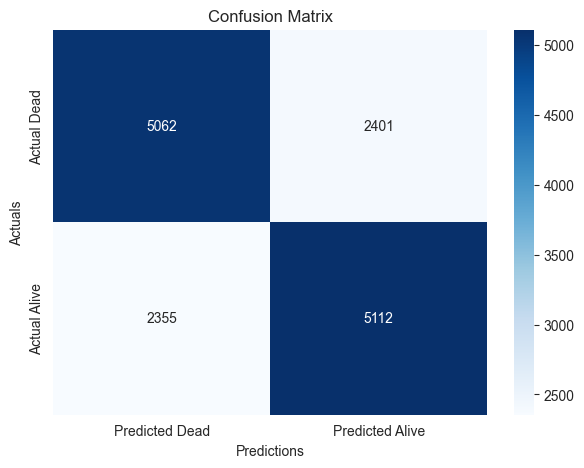

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Model Evaluation

accuracy = accuracy_score(y_test, y_pred_nominal)
cm = confusion_matrix(y_test, y_pred_nominal)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

## Visualization
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Dead', 'Predicted Alive'], yticklabels=['Actual Dead', 'Actual Alive'])
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

## (e) - Interpretation of the seatbelt and ageOFocc parameter

In the trained model the coefficients are:

- $\text{seatbelt(none)} = -1.3971$, the negative parameter tells us that not using a seatbelt significantly decreases the chance to survive a crash. It is also the factor that decreases the probability of surviving the most between the other parameters.
- $\text{ageOFocc} = -0.0262$, this means that an older occupant will slightly decrease the probability of surviving. As the number is close to zero it means that compared to other parameters like *airbag* or *seatbelt* it will not contribute as much to the outcome of the prediction. 

In [17]:
# Summary of the trained model to consult the coef.
glm_eval.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                       
=========================================================================================
Dep. Variable:     ['dead[alive]', 'dead[dead]']   No. Observations:                34836
Model:                                       GLM   Df Residuals:                    34829
Model Family:                           Binomial   Df Model:                            6
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -20489.
Date:                           Fri, 12 Apr 2024   Deviance:                       40978.
Time:                                   00:12:13   Pearson chi2:                 3.48e+04
No. Iterations:                                4   Pseudo R-squ. (CS):             0.1894
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0061      0.044     45.931      0.000       1.920       2.092
C(airbag)[T.none]      -1.0378      0.036    -28.830      0.000      -1.108      -0.967
C(seatbelt)[T.none]    -1.3955      0.025    -55.361      0.000      -1.445      -1.346
C(frontal)[T.1]         1.0777      0.026     40.903      0.000       1.026       1.129
C(sex)[T.m]            -0.2951      0.025    -11.991      0.000      -0.343      -0.247
C(deploy)[T.1]         -0.8413      0.038    -21.867      0.000      -0.917      -0.766
ageOFocc               -0.0261      0.001    -41.623      0.000      -0.027      -0.025
=======================================================================================
"""

## (f) - Predictions given a scenario

By calculating the odds of not surviving using the formula $odds = \frac{1-P}{P}$ (where $P$ is the probability of not surviving) the results are:

- Scenario **1**:
For this scenario where there is no airbag and belt, the odds for the occupant not surviving is $7.5$.
- Scenario **2**:
In this case where belt and airbag is present and deployed, the odds of the occupant not surviving are significantly lower with a value of just $0.2855$.

In [18]:
# Dataframe containing both scenarios
scenarios = pd.DataFrame({
    'airbag': ['none', 'airbag'],
    'seatbelt': ['none', 'belted'],  
    'frontal': [1, 1],
    'sex': ['f', 'f'],        
    'ageOFocc': [70, 70],  
    'deploy': [1, 0]   
})

prob_surviving = glm_eval.predict(scenarios)
odds_not_surviving = (1 - prob_surviving) / prob_surviving

for i, odds in enumerate(odds_not_surviving, 1):
    print(f"Scenario {i}: Odds of not surviving= {odds:.4f}")

Scenario 1: Odds of not surviving= 7.5482
Scenario 2: Odds of not surviving= 0.2855


# Question 3 - Intl. Student Flow between countries

In [19]:
# Import of the dataset
q3_df = pd.read_excel('data_q3.xlsx')
#q3_df # Commented to avoid cluttering the pdf

## (a) - Data Pre-processing

The provided dataset has 10 missing values (in the considered variables), to avoid problems records with missing values are dropped.

As clustering algorithms will be applied, a dataset called *q3_scaled_df* is created, this dataset is preprocessed from the dataset *q3_cleaned_df* (that contains only variables of interest and no records with missing values) as follows:

- All categorical and unique variables are removed. This is important as they can't be used to measure the Euclidean distance between data points.
- All the numerical data is scaled so that they all contribute equally to the distance calculation.

In [20]:
from sklearn.preprocessing import StandardScaler

## Selection of column of interest
q3_clean_df = q3_df[['InboundRatio', 'InternationalStudentsNO', 'KOFPoGI', 'KOFEcGI', 'KOFSoGI', 'ISCED5 Percentage', 'ISCED6 Percentage', 'ISCED7 Percentage', 'ISCED8 Percentage', 'top_50_count', 'top_100_count', 'top_500_count', 'top_1000_count', 'WESP', 'country_x']]

## Missing data
print(f"Number of missing data: {q3_clean_df.isnull().sum().sum()}")
## Duplicated data
print(f"Number of duplicated data: {q3_clean_df.duplicated().sum()}")

## Drop of records with missing data
q3_clean_df = q3_clean_df.dropna()

## Drop categorical / unique values
q3_scaled_df = q3_clean_df.drop(['WESP', 'country_x'], axis=1)

## Scale the data (to apply K-Means)
scaler = StandardScaler()
q3_scaled_df = scaler.fit_transform(q3_scaled_df)

Number of missing data: 10
Number of duplicated data: 0


## (b) - K-Mean Cluster Analysis

By applying using the *Elbow method* and *silhouette score* the ideal number of clusters looks to be $K = 3$.
This is because in the first plot the elbow point appears to be where $K = 3$ as the next points looks to be in a line, and paired with the silhouette score plot it shows 3 as a potential candidate.

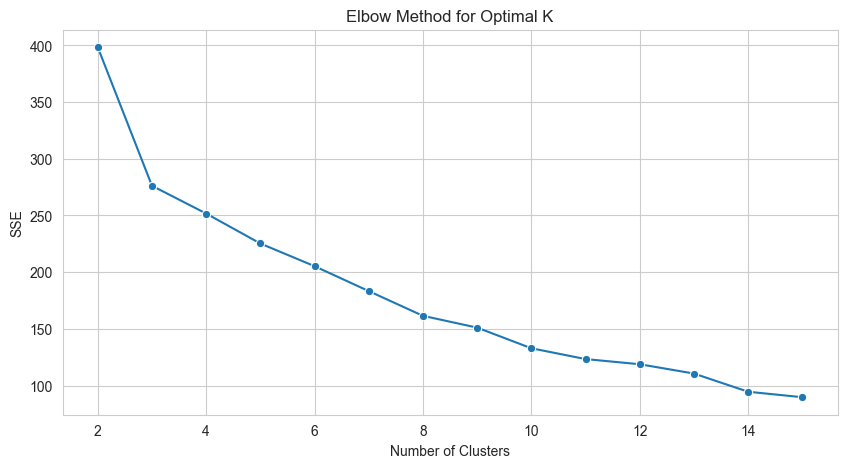

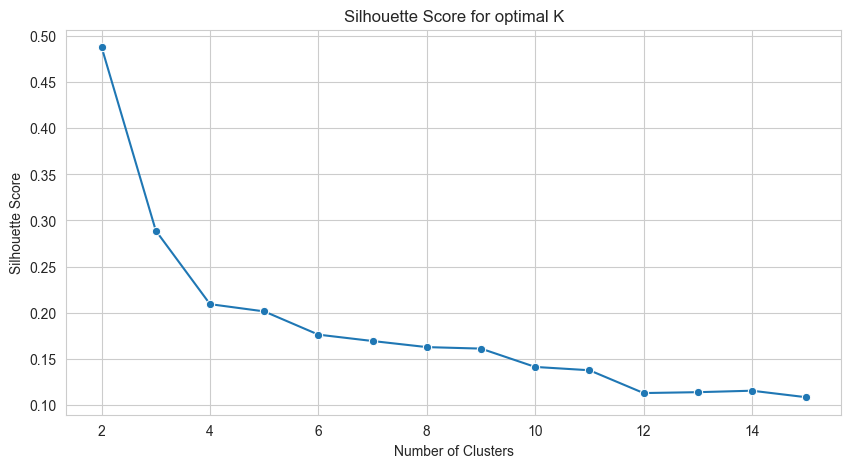

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# KMeans analysis

sse = []
silhouette_coeff = []
range_n_clusters = range(2, 16)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(q3_scaled_df)
    sse.append(kmeans.inertia_)
    score = silhouette_score(q3_scaled_df, kmeans.labels_)
    silhouette_coeff.append(score)

# Elbow Method
plt.figure(figsize=(10, 5))
sns.lineplot(x=range_n_clusters, y=sse, marker="o", dashes=False)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

# Silhouette score
plt.figure(figsize=(10, 5))
sns.lineplot(x=range_n_clusters, y=silhouette_coeff, marker="o", dashes=False)
plt.title('Silhouette Score for optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## (c) - Agglomerative cluster analysis

By using the dendrogram it seems that the best number of clusters is still $K = 3$. This is because the best "cut" appears to be at the third level (in the plot below, right to left). The cut was made at the third level as it is the only level where there is a significant distance to the upper level.


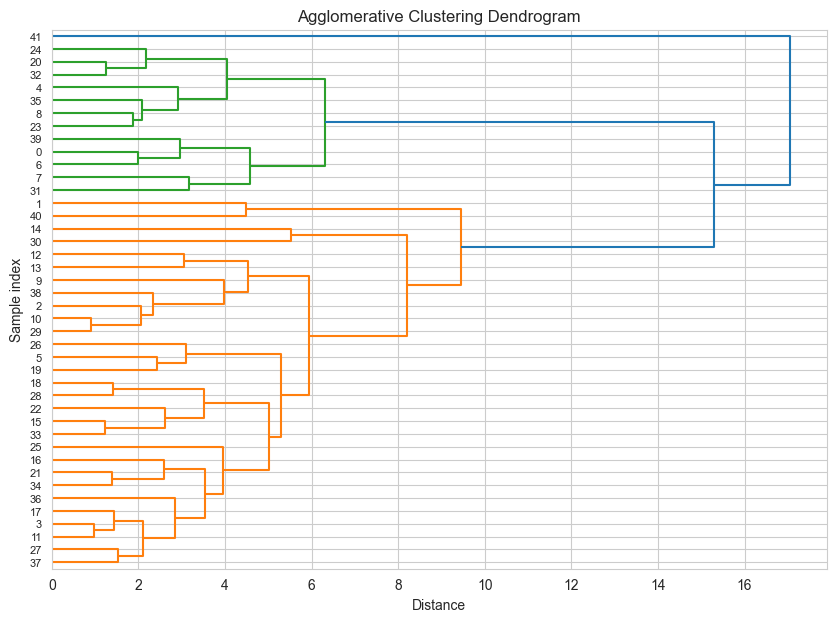

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Agglomerative cl. analysis
linked = linkage(q3_scaled_df, 'ward')

# Plotting the Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='right', distance_sort='descending', show_leaf_counts=True)
plt.title('Agglomerative Clustering Dendrogram')
plt.ylabel('Sample index')
plt.xlabel('Distance')
plt.show()

## (d) - Conclusions

By using the number of clusters $K = 3$ with both K-Means and Agglomerative clustering, the identified clusters contains significant differences in terms of university ranking, number of international students and globalization index.

From the PCA-Reduced plot below it seems that the best cluster set was identified by the Agglomerative Clustering method as it isolated the USA inside his own cluster.

As shown by the plots below, countries that are in the same cluster have a similar globalization index and number of international students. The only outlier is with the United States, which has so many International Students and top ranking universities that in both K-Means and Aggl. clustering it is in his own cluster (along with the UK).

The Number of international Students and top ranking universities seems to also be related with the WESP designation, countries part of the clusters with more top ranking universities are considered Developed and only few developing, while in the cluster with the least number of students and top universities the majority of countries are in the developing category.

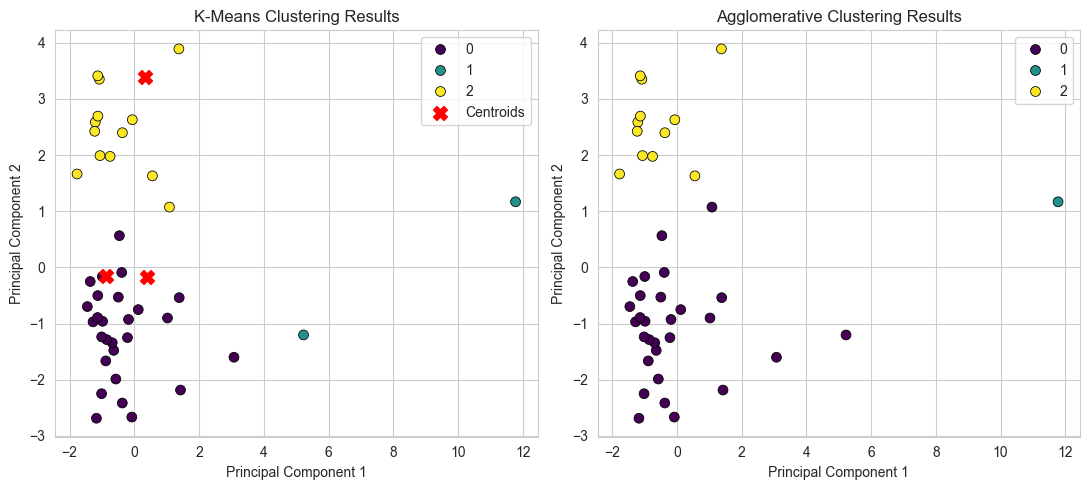

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Apply K-Means + Agglomerative clustering with identified K = 3
# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(q3_scaled_df)
q3_clean_df['ClusterK'] = kmeans.labels_

# Aggl. clustering
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_clustering.fit(q3_scaled_df)
q3_clean_df['ClusterA'] = agg_clustering.labels_

pca = PCA(n_components=2)
q3_reduced = pca.fit_transform(q3_scaled_df)

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

# K-Means Plot
sns.scatterplot(x=q3_reduced[:, 0], y=q3_reduced[:, 1], hue=kmeans.labels_, palette='viridis', s=50, edgecolor='k', legend='full', ax=ax[0])
centroids = kmeans.cluster_centers_
ax[0].scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='red', label='Centroids')
ax[0].set_title('K-Means Clustering Results')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].legend()

# Aggl. Clustering Plot
sns.scatterplot(x=q3_reduced[:, 0], y=q3_reduced[:, 1], hue=agg_clustering.labels_, palette='viridis', s=50, edgecolor='k', legend='full', ax=ax[1])
ax[1].set_title('Agglomerative Clustering Results')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].legend()

plt.tight_layout()
plt.show()

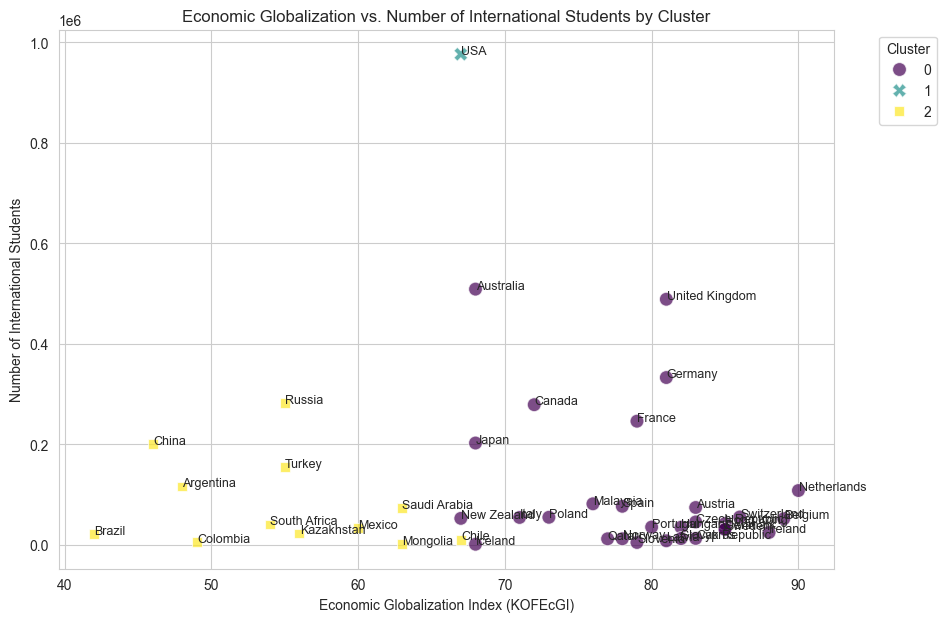

In [24]:
# Plot KOFEcGI vs Inbound Students
plt.figure(figsize=(10, 7))
sns.scatterplot(data=q3_clean_df, x='KOFEcGI', y='InternationalStudentsNO', hue='ClusterA', style='ClusterA', palette='viridis', s=100, alpha=0.7)

plt.title('Economic Globalization vs. Number of International Students by Cluster')
plt.xlabel('Economic Globalization Index (KOFEcGI)')
plt.ylabel('Number of International Students')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Print the country name
for i, point in q3_clean_df.iterrows():
    plt.text(point['KOFEcGI']+0.02, point['InternationalStudentsNO'], str(point['country_x']), fontsize=9, ha='left')

plt.grid(True)
plt.show()

In [25]:
top_50_clusterA = q3_clean_df.groupby('ClusterA')['top_50_count'].sum().reset_index()
top_100_clusterA = q3_clean_df.groupby('ClusterA')['top_100_count'].sum().reset_index()
top_50_clusterK = q3_clean_df.groupby('ClusterK')['top_50_count'].sum().reset_index()
top_100_clusterK = q3_clean_df.groupby('ClusterK')['top_100_count'].sum().reset_index()
print("Agglomerative Clustering results")
print(f'Top 50 universities in each cluster\n{top_50_clusterA}')
print(f'Top 100 universities in each cluster\n{top_100_clusterA}')
print("K-Means Clustering results")
print(f'Top 50 universities in each cluster\n{top_50_clusterK}')
print(f'Top 100 universities in each cluster\n{top_100_clusterK}')

Agglomerative Clustering results
Top 50 universities in each cluster
   ClusterA  top_50_count
0         0            24
1         1            19
2         2             3
Top 100 universities in each cluster
   ClusterA  top_100_count
0         0             54
1         1             33
2         2              8
K-Means Clustering results
Top 50 universities in each cluster
   ClusterK  top_50_count
0         0            14
1         1            27
2         2             5
Top 100 universities in each cluster
   ClusterK  top_100_count
0         0             31
1         1             51
2         2             13


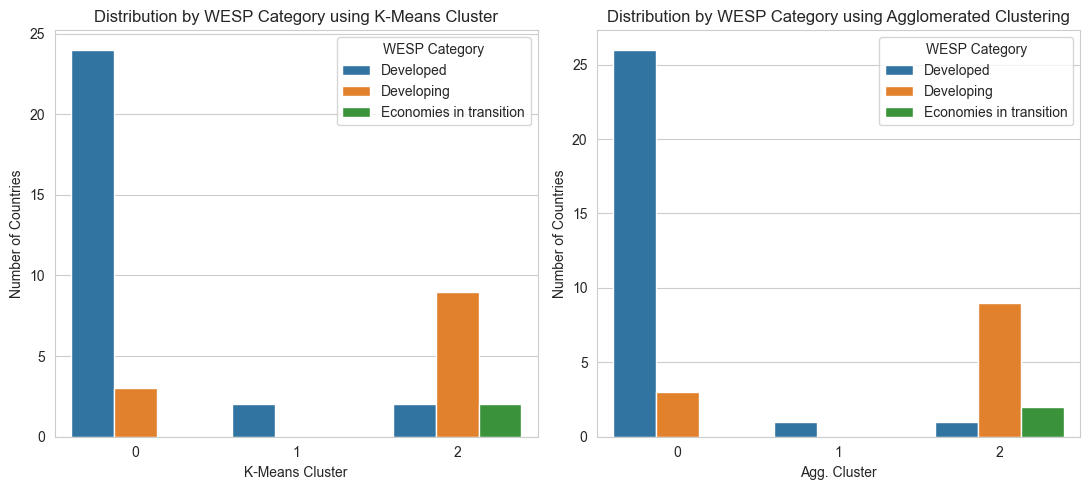

In [26]:
wesp_distributionK = q3_clean_df.groupby(['ClusterK', 'WESP']).size().reset_index(name='Country Count')
wesp_distributionA = q3_clean_df.groupby(['ClusterA', 'WESP']).size().reset_index(name='Country Count')

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

sns.barplot(data=wesp_distributionK, x='ClusterK', y='Country Count', hue='WESP', ax=ax[0])
ax[0].set_title('Distribution by WESP Category using K-Means Cluster')
ax[0].set_xlabel('K-Means Cluster')
ax[0].set_ylabel('Number of Countries')
ax[0].legend(title='WESP Category')

sns.barplot(data=wesp_distributionA, x='ClusterA', y='Country Count', hue='WESP', ax=ax[1])
ax[1].set_title('Distribution by WESP Category using Agglomerated Clustering')
ax[1].set_xlabel('Agg. Cluster')
ax[1].set_ylabel('Number of Countries')
ax[1].legend(title='WESP Category')

plt.tight_layout()
plt.show()